# Plot erasure conversion decoding accuracy

In [1]:
d: float = 3
p: float = 0.001
code: str = f"rsc(d={d},p={p})"
noise: str = "none"

json_filename: str | None = None
speed_json_filename: str | None = None
force_finished: bool = True  # only plot the figure and do not run experiments

In [2]:
ecr_vec: list[float] = [0.2 * e for e in range(5)] + [0.9, 0.95, 0.98, 1]  # erasure conversion rate
c_vec = [0, 50, 1000]
max_iter_vec = [0, 5]
osd_order_vec = [0, 10]

mwpf_decoder_vec = [f"mwpf(c={c})" for c in c_vec] + [f"mwpf(c={c},pass_circuit=1)" for c in c_vec]
bposd0_decoder_vec = [f"bposd(max_iter={max_iter})" for max_iter in max_iter_vec]
bposdn_decoder_vec = [f"bposd(max_iter={max_iter},osd_order={osd_order},osd_method=osd_e)" for max_iter in max_iter_vec for osd_order in osd_order_vec]
bpuf_decoder_vec = [f"bpuf(max_iter={max_iter})" for max_iter in max_iter_vec]

decoder_vec = mwpf_decoder_vec + bposd0_decoder_vec + bposdn_decoder_vec + bpuf_decoder_vec + ["mwpm"]
print("number of decoders:", len(decoder_vec))

number of decoders: 15


In [3]:
from slugify import slugify
from dotmap import DotMap as dmap

if json_filename is None:
    json_filename = "zdat-" + slugify(code) + ".json"
print(json_filename)

if speed_json_filename is None:
    speed_json_filename = "zdat-speed-" + slugify(code) + ".json"
# speed_json_filename = "zdat-speed-rsc-d-3-p-0-001.old.json"
print(speed_json_filename)

zdat-rsc-d-3-p-0-001.json
zdat-speed-rsc-d-3-p-0-001.json


In [4]:
from qec_lego_bench.hpc.monte_carlo import *
from qec_lego_bench.hpc.submitter import *
from qec_lego_bench.hpc.plotter import *
from qec_lego_bench.hpc.job_store import Job, JobStore
from qec_lego_bench.cli.decoding_speed import DecodingSpeedResult

pL_jobs = [
    MonteCarloJob(decoder, ecr, no_detectors)
    for decoder in decoder_vec
    for ecr in ecr_vec
    for no_detectors in [True, False]
]
pL_store = MonteCarloJobExecutor(lambda _: None, pL_jobs, filename=json_filename)

speed_jobs = [
    Job(decoder, ecr, no_detectors)
    for decoder in decoder_vec
    for ecr in ecr_vec
    for no_detectors in [True, False]
]
speed_store = JobStore(
    lambda _: None,
    speed_jobs,
    result_type=DecodingSpeedResult,
    filename=speed_json_filename,
)

## First get plot range

In [5]:
# get logical error rate range
pL_vec = [job.result.stats_of(job).failure_rate_value for job in pL_jobs]
max_pL = max(pL_vec)
min_pL = min(pL_vec)
print(f"max_pL: {max_pL}, min_pL: {min_pL}")

# get decoding time range
time_vec = [job.result.decoding_time for job in speed_jobs]
max_time = max(time_vec)
min_time = min(time_vec)
print(f"max_time: {max_time}, min_time: {min_time}")

max_pL: 0.03441364409506735, min_pL: 2.704697134138383e-06
max_time: 0.0007153261061997498, min_time: 7.826622886218679e-08


## Plot logical error rate data

In [6]:
def prepare_fig():
    fig = plt.figure()
    fig.set_size_inches(6.5, 6)
    ax = fig.gca()
    ax.clear()
    ax.set_xlabel("erasure conversion rate $R$")
    ax.set_ylabel("logical error rate $p_L$")
    ax.set_xlim(-0.05, 1.05)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 1])
    ax.set_xticklabels(["0", "20%", "40%", "60%", "80%", "90%", "100%"])
    ax.set_ylim(1e-8, 4e-2)
    ax.set_yscale("log")
    ax.set_title(f"Rotated Surface Code d=3, p=0.1%, circuit-level noise")
    return fig, ax


def draw_curve(
    ax,
    decoder: str,
    no_detectors: bool,
    label: str,
    zorder: int | None = None,
    fmt: str = ".:",
    show: bool = True,
    color: str | None = None,
):
    x_vec = []
    y_vec = []
    err_vec = []
    for ecr in ecr_vec:
        pL_job = pL_store.get_job(decoder, ecr, no_detectors)
        # speed_job = speed_store.get_job(decoder)
        stats = pL_job.result.stats_of(pL_job)
        x_vec.append(ecr)
        y_vec.append(stats.failure_rate_value)
        err_vec.append(stats.failure_rate_uncertainty)
    if show:
        ax.errorbar(
            x_vec,
            y_vec,
            err_vec,
            zorder=zorder,
            fmt=fmt,
            markersize=5,
            label=label,
            color=color,
        )
    else:
        ax.errorbar(
            [0, 0.2],
            [3e-2, 3e-2],
            [0],
            zorder=zorder,
            fmt=fmt,
            markersize=5,
            color="white",
            label="  ",
        )

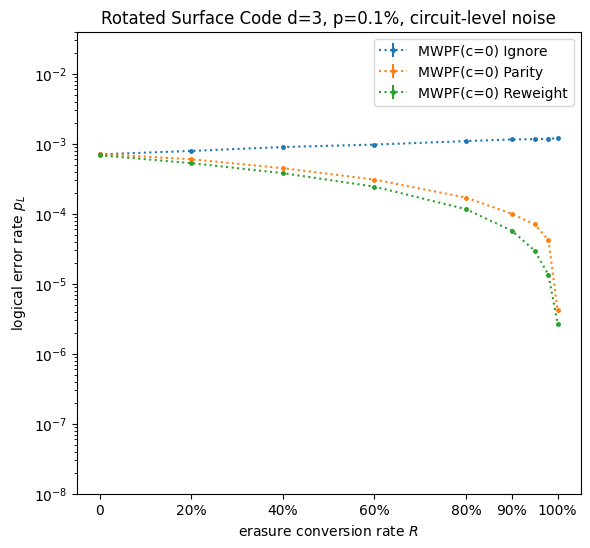

In [7]:
fig, ax = prepare_fig()
draw_curve(ax, "mwpf(c=0)", True, "MWPF(c=0) Ignore")
draw_curve(ax, "mwpf(c=0)", False, "MWPF(c=0) Parity")
draw_curve(ax, "mwpf(c=0,pass_circuit=1)", False, "MWPF(c=0) Reweight")
ax.legend()

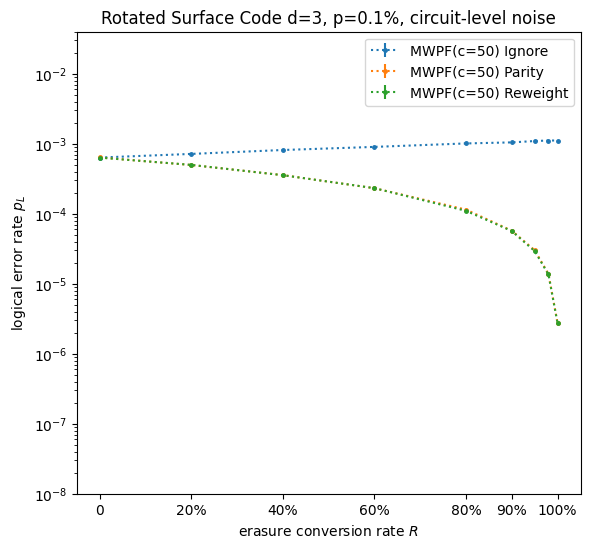

In [8]:
fig, ax = prepare_fig()
draw_curve(ax, "mwpf(c=50)", True, "MWPF(c=50) Ignore")
draw_curve(ax, "mwpf(c=50)", False, "MWPF(c=50) Parity")
draw_curve(ax, "mwpf(c=50,pass_circuit=1)", False, "MWPF(c=50) Reweight")
ax.legend()

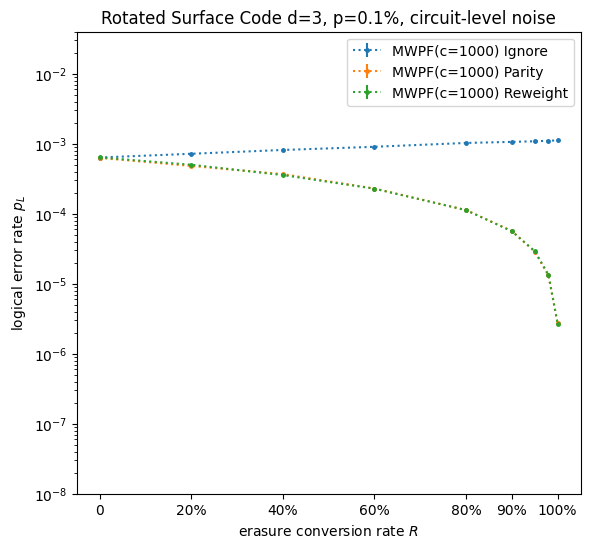

In [9]:
fig, ax = prepare_fig()
draw_curve(ax, "mwpf(c=1000)", True, "MWPF(c=1000) Ignore")
draw_curve(ax, "mwpf(c=1000)", False, "MWPF(c=1000) Parity")
draw_curve(ax, "mwpf(c=1000,pass_circuit=1)", False, "MWPF(c=1000) Reweight")
ax.legend()

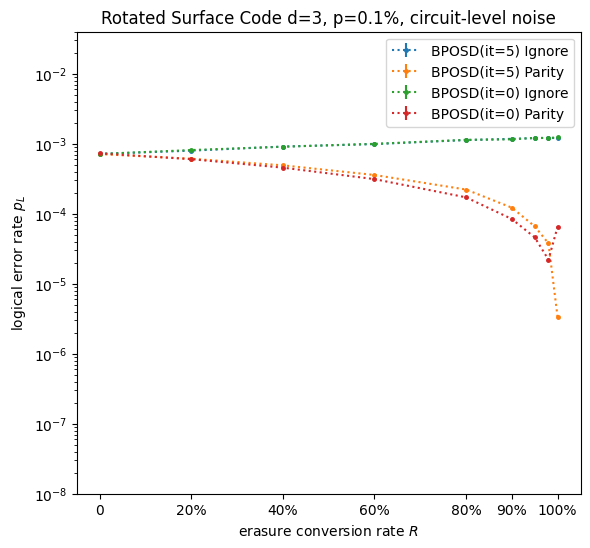

In [10]:
fig, ax = prepare_fig()
draw_curve(ax, "bposd(max_iter=5)", True, "BPOSD(it=5) Ignore")
draw_curve(ax, "bposd(max_iter=5)", False, "BPOSD(it=5) Parity")
draw_curve(ax, "bposd(max_iter=0)", True, "BPOSD(it=0) Ignore")
draw_curve(ax, "bposd(max_iter=0)", False, "BPOSD(it=0) Parity")
ax.legend()

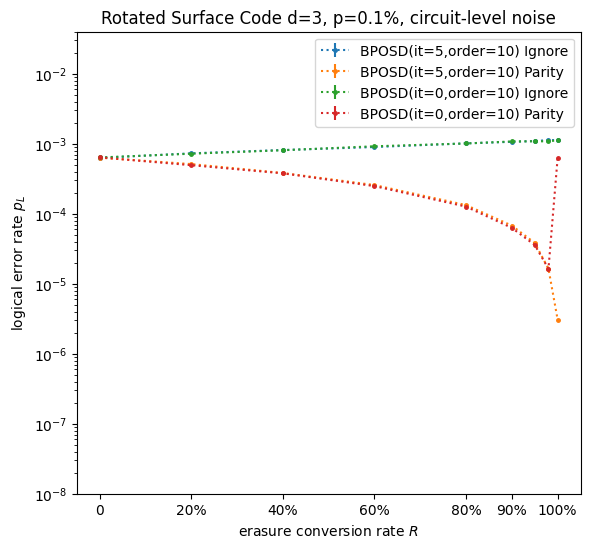

In [11]:
fig, ax = prepare_fig()
draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", True, "BPOSD(it=5,order=10) Ignore")
draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", False, "BPOSD(it=5,order=10) Parity")
draw_curve(ax, "bposd(max_iter=0,osd_order=10,osd_method=osd_e)", True, "BPOSD(it=0,order=10) Ignore")
draw_curve(ax, "bposd(max_iter=0,osd_order=10,osd_method=osd_e)", False, "BPOSD(it=0,order=10) Parity")
ax.legend()

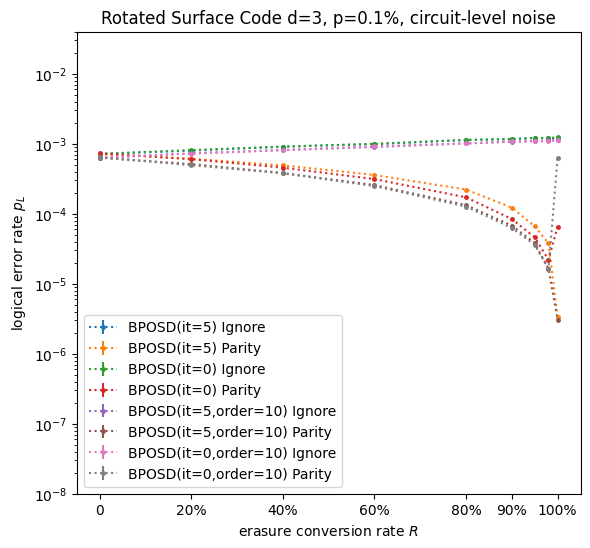

In [12]:
fig, ax = prepare_fig()
draw_curve(ax, "bposd(max_iter=5)", True, "BPOSD(it=5) Ignore")
draw_curve(ax, "bposd(max_iter=5)", False, "BPOSD(it=5) Parity")
draw_curve(ax, "bposd(max_iter=0)", True, "BPOSD(it=0) Ignore")
draw_curve(ax, "bposd(max_iter=0)", False, "BPOSD(it=0) Parity")
draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", True, "BPOSD(it=5,order=10) Ignore")
draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", False, "BPOSD(it=5,order=10) Parity")
draw_curve(ax, "bposd(max_iter=0,osd_order=10,osd_method=osd_e)", True, "BPOSD(it=0,order=10) Ignore")
draw_curve(ax, "bposd(max_iter=0,osd_order=10,osd_method=osd_e)", False, "BPOSD(it=0,order=10) Parity")
ax.legend()

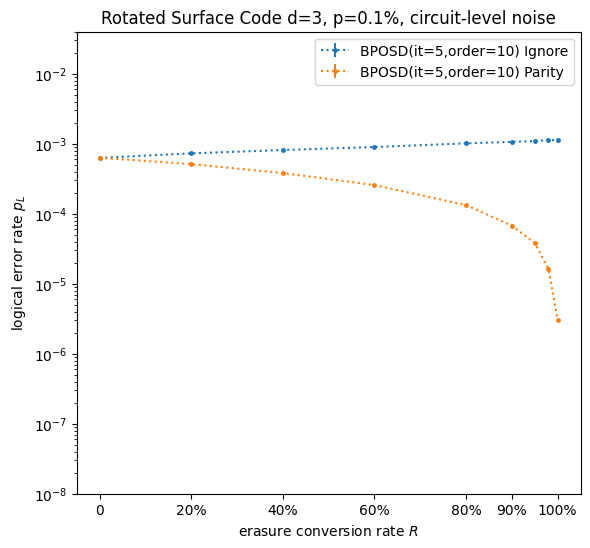

In [13]:
fig, ax = prepare_fig()
draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", True, "BPOSD(it=5,order=10) Ignore")
draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", False, "BPOSD(it=5,order=10) Parity")
ax.legend()

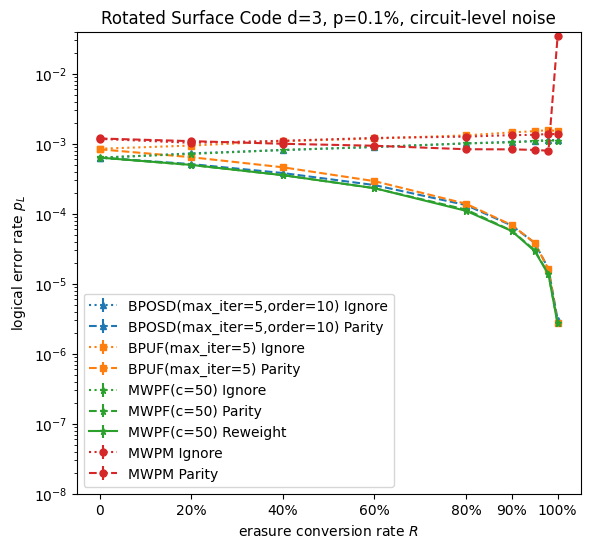

In [14]:
def draw(bit_vec: list[bool]):
    fig, ax = prepare_fig()
    draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", True, "BPOSD(max_iter=5,order=10) Ignore", color="tab:blue", fmt="^:", show=bit_vec[0])
    draw_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", False, "BPOSD(max_iter=5,order=10) Parity", color="tab:blue", fmt="^--", show=bit_vec[1])
    draw_curve(ax, "bpuf(max_iter=5)", True, "BPUF(max_iter=5) Ignore", color="tab:orange", fmt="s:", show=bit_vec[2])
    draw_curve(ax, "bpuf(max_iter=5)", False, "BPUF(max_iter=5) Parity", color="tab:orange", fmt="s--", show=bit_vec[3])
    draw_curve(ax, "mwpf(c=50)", True, "MWPF(c=50) Ignore", color="tab:green", fmt="*:", show=bit_vec[4])
    draw_curve(ax, "mwpf(c=50)", False, "MWPF(c=50) Parity", color="tab:green", fmt="*--", show=bit_vec[5])
    draw_curve(ax, "mwpf(c=50,pass_circuit=1)", False, "MWPF(c=50) Reweight", color="tab:green", fmt="*-", show=bit_vec[6])
    draw_curve(ax, "mwpm", True, "MWPM Ignore", color="tab:red", fmt="o:", show=bit_vec[7])
    draw_curve(ax, "mwpm", False, "MWPM Parity", color="tab:red", fmt="o--", show=bit_vec[8])
    ax.legend()
draw([1,1,1,1,1,1,1,1,1])

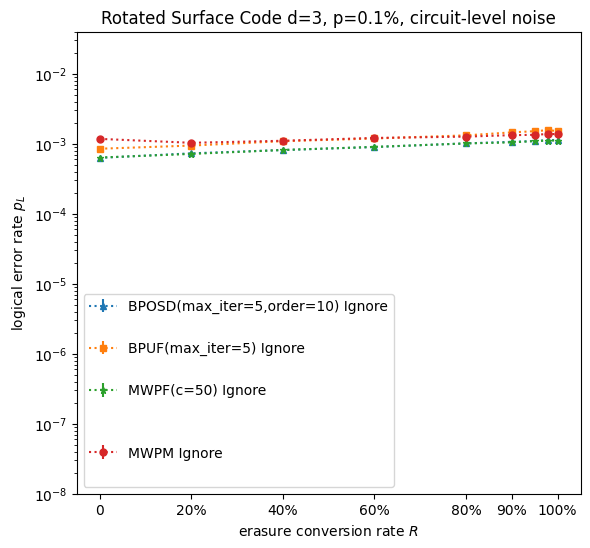

In [15]:
draw([1,0,1,0,1,0,0,1,0])

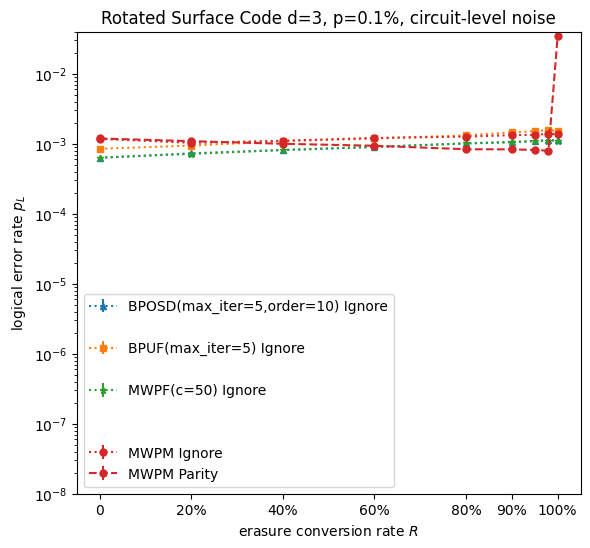

In [16]:
draw([1,0,1,0,1,0,0,1,1])

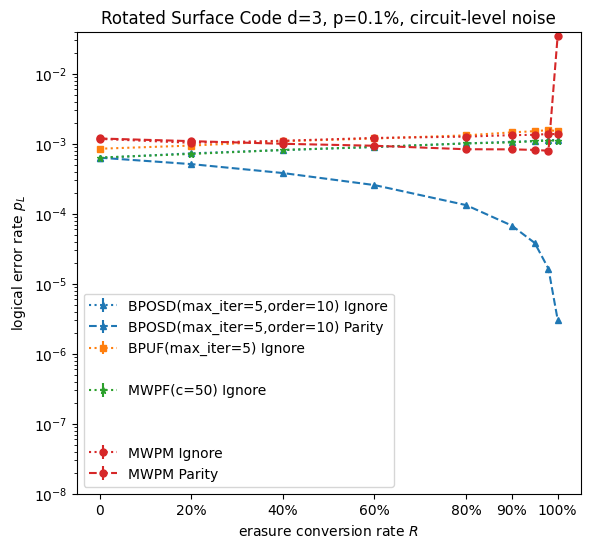

In [17]:
draw([1,1,1,0,1,0,0,1,1])

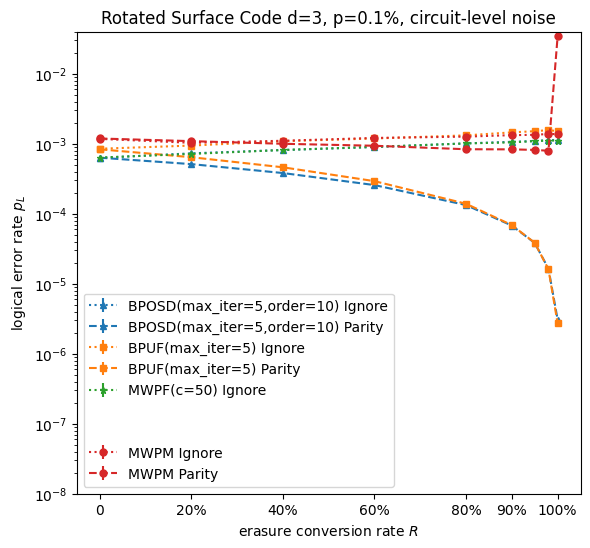

In [18]:
draw([1,1,1,1,1,0,0,1,1])

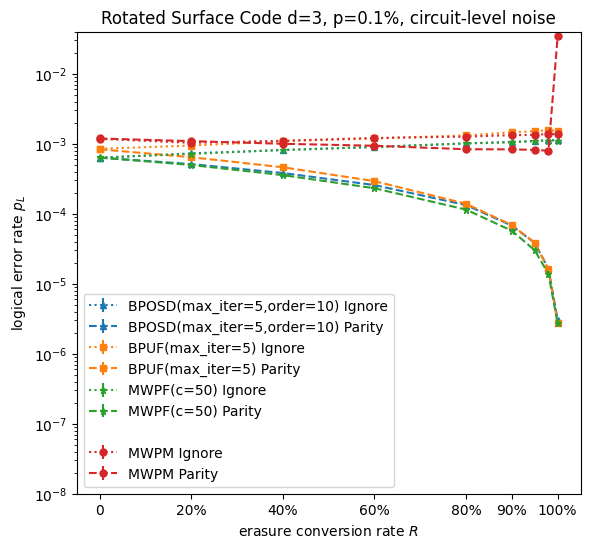

In [19]:
draw([1,1,1,1,1,1,0,1,1])

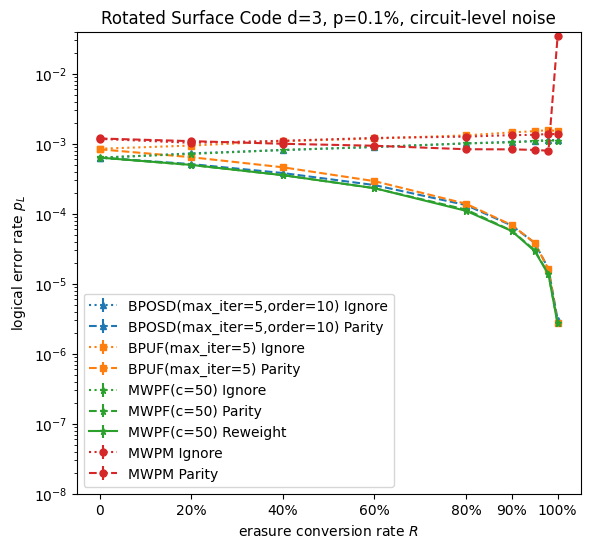

In [20]:
draw([1,1,1,1,1,1,1,1,1])

## Plot decoding speed data

In [21]:
def prepare_speed_fig():
    fig = plt.figure()
    fig.set_size_inches(6.5, 6)
    ax = fig.gca()
    ax.clear()
    ax.set_xlabel("erasure conversion rate $R$")
    ax.set_ylabel("decoding speed $s$")
    ax.set_xlim(-0.05, 1.05)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 1])
    ax.set_xticklabels(["0", "20%", "40%", "60%", "80%", "90%", "100%"])
    ax.set_ylim(1e-8, 2e-2)
    ax.set_yscale("log")
    ax.set_title(f"Rotated Surface Code d=3, p=0.1%, circuit-level noise")
    return fig, ax


def draw_speed_curve(
    ax,
    decoder: str,
    no_detectors: bool,
    label: str,
    zorder: int | None = None,
    fmt: str = ".:",
    show: bool = True,
    color: str | None = None,
):
    x_vec = []
    y_vec = []
    for ecr in ecr_vec:
        speed_job = speed_store.get_job(decoder, ecr, no_detectors)
        decoding_time = speed_job.result.decoding_time
        x_vec.append(ecr)
        y_vec.append(decoding_time)
    if show:
        ax.errorbar(
            x_vec,
            y_vec,
            zorder=zorder,
            fmt=fmt,
            markersize=5,
            label=label,
            color=color,
        )
    else:
        ax.errorbar(
            [0, 0.2],
            [3e-2, 3e-2],
            zorder=zorder,
            fmt=fmt,
            markersize=5,
            color="white",
            label="  ",
        )

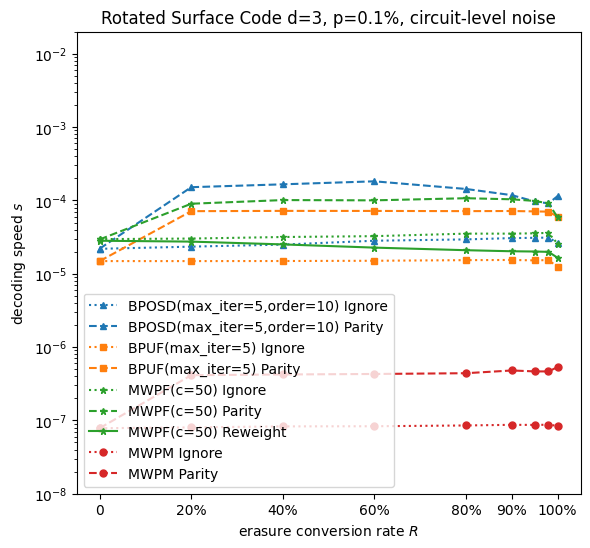

In [22]:
def draw_speed(bit_vec: list[bool]):
    fig, ax = prepare_speed_fig()
    draw_speed_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", True, "BPOSD(max_iter=5,order=10) Ignore", color="tab:blue", fmt="^:", show=bit_vec[0])
    draw_speed_curve(ax, "bposd(max_iter=5,osd_order=10,osd_method=osd_e)", False, "BPOSD(max_iter=5,order=10) Parity", color="tab:blue", fmt="^--", show=bit_vec[1])
    draw_speed_curve(ax, "bpuf(max_iter=5)", True, "BPUF(max_iter=5) Ignore", color="tab:orange", fmt="s:", show=bit_vec[2])
    draw_speed_curve(ax, "bpuf(max_iter=5)", False, "BPUF(max_iter=5) Parity", color="tab:orange", fmt="s--", show=bit_vec[3])
    draw_speed_curve(ax, "mwpf(c=50)", True, "MWPF(c=50) Ignore", color="tab:green", fmt="*:", show=bit_vec[4])
    draw_speed_curve(ax, "mwpf(c=50)", False, "MWPF(c=50) Parity", color="tab:green", fmt="*--", show=bit_vec[5])
    draw_speed_curve(ax, "mwpf(c=50,pass_circuit=1)", False, "MWPF(c=50) Reweight", color="tab:green", fmt="*-", show=bit_vec[6])
    draw_speed_curve(ax, "mwpm", True, "MWPM Ignore", color="tab:red", fmt="o:", show=bit_vec[7])
    draw_speed_curve(ax, "mwpm", False, "MWPM Parity", color="tab:red", fmt="o--", show=bit_vec[8])
    ax.legend(loc='lower left')
draw_speed([1,1,1,1,1,1,1,1,1])

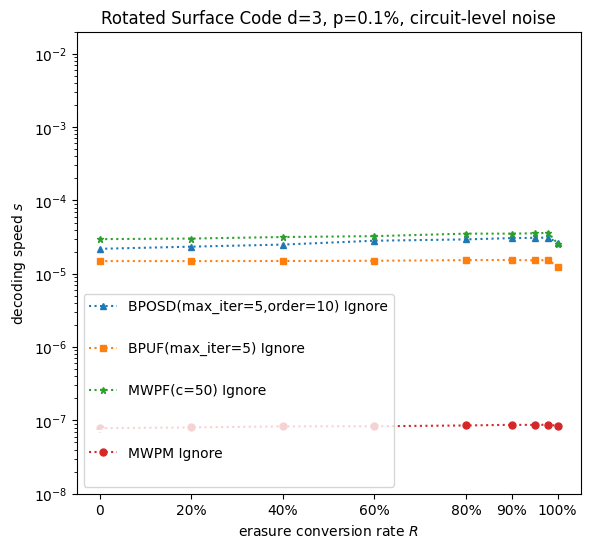

In [23]:
draw_speed([1,0,1,0,1,0,0,1,0])

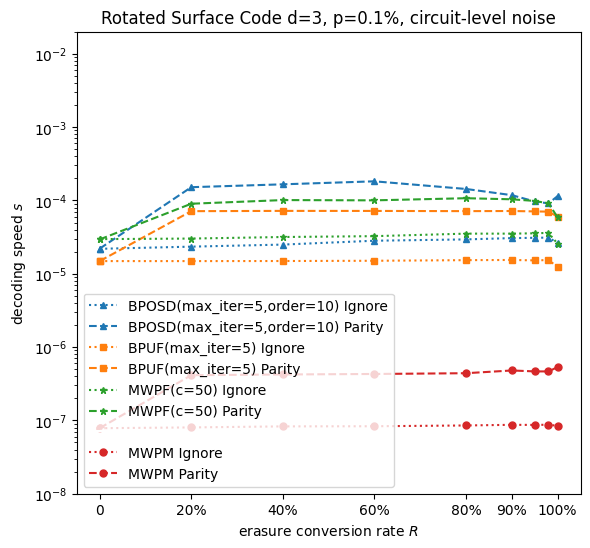

In [24]:
draw_speed([1,1,1,1,1,1,0,1,1])

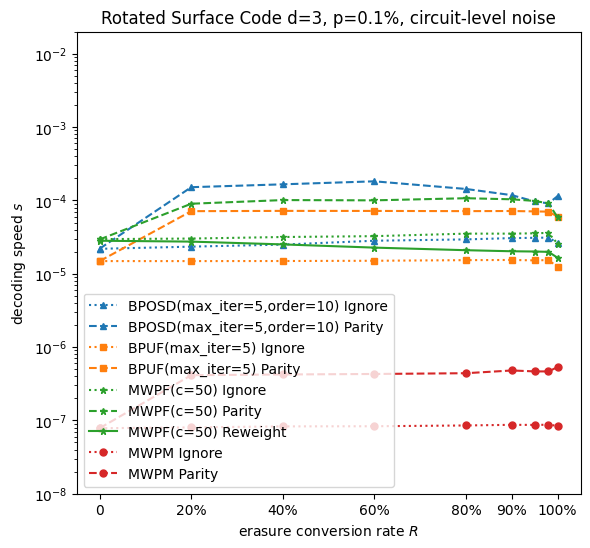

In [25]:
draw_speed([1,1,1,1,1,1,1,1,1])